In [1]:
import paddle
import paddle.fluid as fluid
from paddle.fluid.dygraph import Linear
import numpy as np
import utils

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image

In [2]:
def draw_line(costs, learning_rate):
    """
    动态绘制训练中costs的曲线
    :param costs: 记录了训练过程的cost变化的list
    """
    plt.clf()
    plt.plot(costs)
    plt.title("Learning rate = %f" % (learning_rate))
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.pause(0.05)
    display.clear_output(wait=True)

In [3]:
def get_data():
    """
    数据预处理
    """
    # 获取原始数据
    train_x_ori, train_y_set, test_x_ori, test_y_set, classes = utils.load_data_sets()
    # m_train: 训练集样本数量
    m_train = train_x_ori.shape[0]
    # m_test: 测试集样本数量
    m_test = test_x_ori.shape[0]
    # 图片样本长宽像素数量
    num_px_x = train_x_ori.shape[1]
    num_px_y = train_x_ori.shape[2]

    # 定义输入数据维度，注意样本图像是3通道
    DATA_DIM = num_px_x * num_px_y * 3

    # 转换数据形状为
    train_x_flatten = train_x_ori.reshape(m_train, -1)
    test_x_flatten = test_x_ori.reshape(m_test, -1)

    # 归一化处理
    train_x_set = train_x_flatten / 255
    test_x_set = test_x_flatten / 255

    # 合并数据
    train_set = np.hstack((train_x_set, train_y_set.T))
    test_set = np.hstack((test_x_set, test_y_set.T))

    return train_set, test_set, DATA_DIM, classes

In [4]:
# 读取数据集以及相关参数
global TRAIN_SET
global TEST_SET
global DATA_DIM
global CLASSES
TRAIN_SET, TEST_SET, DATA_DIM, CLASSES = get_data()

In [5]:
def read_data(data_set):
    """
    构造reader
    :param data_set: 要获取的数据的数据集
    :return: reader: 用户返回训练数据及数据标签的生成器(generator)
    """
    def reader():
        """
        一个reader生成器
        :return: 每次训练数据及数据标签
        data[:-1]: 训练数据
        data[-1:]: 数据标签
        """
        for data in data_set:
            yield data[:-1], data[-1:]
    return reader

In [6]:
# 定义reader
# 定义buf_size和batch_size大小
buf_size = 1000
batch_size = 256

# 训练集reader
train_reader = fluid.io.batch(
    reader=paddle.reader.shuffle(
        reader=read_data(TRAIN_SET),
        buf_size=buf_size
    ),
    batch_size=batch_size
)
# 测试集reader
test_reader = fluid.io.batch(
    reader=paddle.reader.shuffle(
        reader=read_data(TEST_SET),
        buf_size=buf_size
    ),
    batch_size=batch_size
)

In [7]:
# 定义softmax分类器
class Softmax_regression(fluid.dygraph.Layer):
    def __init__(self, name_scope):
        super(Softmax_regression, self).__init__(name_scope)
        # 输出层，全连接层，输出大小为2，对应结果的两个类别，激活函数为softmax
        self.fc = Linear(input_dim=DATA_DIM, output_dim=2, act='softmax')
        
    
    # 网络的前向计算函数
    def forward(self, x):
        x = self.fc(x)
        return x

In [ ]:
# 定义飞桨动态图工作环境
with fluid.dygraph.guard():
    # 实例化模型
    # Softmax分类器
    model = Softmax_regression('catornocat')
    
    # 开启模型训练模式
    model.train()
    # 使用Adam优化器
    # 学习率为0.01
    opt = fluid.optimizer.Adam(learning_rate=0.01, parameter_list=model.parameters())
    # 迭代次数设为200
    EPOCH_NUM = 200


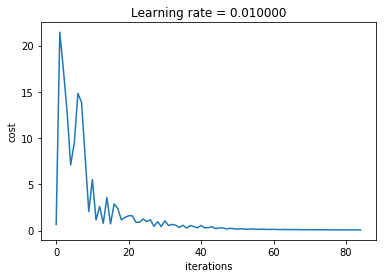

In [ ]:
with fluid.dygraph.guard():
    # 记录每次的损失值，用于绘图
    costs = []
    # 定义外层循环
    for pass_num in range(EPOCH_NUM):
        # 定义内层循环
        for batch_id,data in enumerate(train_reader()):
            # 调整数据shape使之适合模型
            images = np.array([x[0].reshape(DATA_DIM) for x in data],np.float32)
            labels = np.array([x[1] for x in data]).astype('int64').reshape(-1,1)
            
            # 将numpy数据转为飞桨动态图variable形式
            image = fluid.dygraph.to_variable(images)
            label = fluid.dygraph.to_variable(labels)
            
            # 前向计算
            predict = model(image)

            # 计算损失
            # 使用交叉熵损失函数
            loss = fluid.layers.cross_entropy(predict,label)
            avg_loss = fluid.layers.mean(loss)

            # 计算精度
            # acc = fluid.layers.accuracy(predict,label)
            
            # 绘图
            costs.append(avg_loss.numpy()[0])
            draw_line(costs, 0.01)

            # 反向传播
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.minimize(avg_loss)
            # 清除梯度
            model.clear_gradients()

    # 保存模型文件到指定路径
    fluid.save_dygraph(model.state_dict(), 'catornocat')

In [ ]:
# 模型评估
with fluid.dygraph.guard():
    # 读取模型
    # 参数为保存模型参数的文件地址
    model_dict, _ = fluid.load_dygraph('catornocat')
    # 加载模型参数
    model.load_dict(model_dict)
    #评估模式
    model.eval()
    
    # 读取测试集数据
    data = next(test_reader())

    # 调整数据shape使之适合模型
    images = np.array([x[0].reshape(DATA_DIM) for x in data],np.float32)
    labels = np.array([x[1] for x in data]).astype('int64').reshape(1, -1)[0]
    
    # 将numpy数据转为飞桨动态图variable形式
    image = fluid.dygraph.to_variable(images)
    
    # 前向计算
    predict = model(image)

    # 统计预测结果
    # 将预测结果转为numpy数据类型
    predict = predict.numpy()
    predict = np.argmax(predict, axis = 1)
    
    # 记录预测正确的样本数量
    num = 0
    for index in range(len(predict)):
        if labels[index] == predict[index]:
            num += 1    
        print("index {}, truth {}, infer {}".format(index, labels[index], predict[index]))
    print("test accuracy {}%".format(num/len(predict)*100))

In [ ]:
# 使用单张图片测试
# 预览测试图片
index = 11
image = np.reshape(TEST_SET[index][:-1], (64, 64, 3))
plt.imshow(image)
plt.show()
print(
        "\nThe label of this picture is " + str(TEST_SET[index, -1])
        + ", 1 means it's a cat picture, 0 means not "
        + "\nYou predict that it's a "
        + CLASSES[int(predict[index])].decode("utf-8")
        + " picture. \nCongrats!"
    )

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 